In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#%matplotlib nbagg
%matplotlib notebook

To predict the occurency of an eclipse we solve the N-body problem for the three bodies Earth, Moom and Sun.

In [2]:
def n_body_diff_eqs(t, r, ms, G=1):
    """
    Returns the differential equations to solve
    t: array-like
        Time interval to obtain the solution of the 
        differential equation.
        
    r: array-like
        Initial conditions of the differential equations.
        The length must be 6*N since for each body there
        must be 3 initial conditions for the position (x,
        y, z) and 3 for the velocity (vx, vy, vz).
        Then, r has the following structure r = [x1, y1,
        z1, vx1, vx2, vx3, x2, y2, z2, vx2, vy2, vz2,...]. 
        
    ms: array-like
        Array of length N containing the masses of the N
        bodies.
        
    G: float
        Universal gravitational constant. Default value is
        set to 1 due to the use of the canonical units. 
    """
    
    #Number of bodies. 
    n = 6
    N = int(len(r)/n)
    
    #Equations
    ecs = np.zeros(len(r))
    
    for i in range(N):
        dvdt_i = [0, 0, 0]
        
        for j in range(N):
            if i != j:
                d = np.sqrt((r[6*j+0]-r[6*i+0])**2 +
                            (r[6*j+1]-r[6*i+1])**2 +
                            (r[6*j+2]-r[6*i+2])**2 )
        
                for k in range(3):
                    #Acceleration dv/dt
                    dvdt_i[k] += G*ms[j]*( r[6*j+k] - r[6*i+k] ) / d**3
                    
        for l in range(3):
            ecs[6*i + l] = r[6*i + 3 + l]
            ecs[6*i + 3 + l] = dvdt_i[l] 
            
    return ecs


def plot_n_body_sol(sol, labels=False, draw_path=True, draw_init=True, draw_end=False, figsize=(9,9)):
    """
    Plots the solution of the N-body problem.
    sol: array-like
        Array of shape (len(ts), 6*N) containing the so-
        lution of the N-body problem.
        
    labels: bool/array-like
        If type is array-like then the array must content
        the names of the N bodies for which the problem 
        was solved.
    
    draw_path: bool
        Draw the path that each particule follows in the 
        time.
    
    draw_init: bool
        Draw the initial position of the N particles.
        
    draw_end: bool
        Draw the last position of the particule in the time
        of the simulation.
        
    figsize: tuple
        tuple containing the dimensions of the plot.
    """
    #Number of bodies
    N = int(sol.shape[1]/6)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection="3d")
    font_label = {
            'family': 'serif',
            'weight': 'normal',
            'size': 8}
    
    font_label2 = {
            'family': 'serif',
            'weight': 'normal',
            'size': 10}
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    if np.array(labels).any:
        for i in range(N):
            if draw_path:    ax.plot(sol.T[6*i+0],     sol.T[6*i+1],     sol.T[6*i+2],    c=colors[i])
            if draw_end:  ax.scatter(sol.T[6*i+0][-1], sol.T[6*i+1][-1], sol.T[6*i+2][-1],c=colors[i], marker="o")
            if draw_init: ax.scatter(sol.T[6*i+0][0],  sol.T[6*i+1][0],  sol.T[6*i+2][0], c=colors[i], 
                                     label=labels[i], marker="o")

        plt.legend(loc="lower center", ncol=len(labels),
                   fancybox=True, shadow=True,
                   mode="expand",prop=font_label)

    else:
        for i in range(N):
            ax.plot(sol.T[6*i+0], sol.T[6*i+1], sol.T[6*i+2])
            ax.scatter(sol.T[6*i+0][0], sol.T[6*i+1][0], sol.T[6*i+2][0], "o")
    
    ax.set_xlabel("X [AU]", fontdict=font_label2)
    ax.set_ylabel("Y [AU]", fontdict=font_label2)
    ax.set_zlabel("Z [AU]", fontdict=font_label2)
    ax.set_zlim(ax.get_xlim())
    plt.tight_layout()

# Units

In this notebook we are going to use canonical units. The unit of mass is the mass of the Sun, and we set, as usual, $G=1$. 

In [3]:
#Canonical units
m  = 1
km = 1000*m
kg = 1
s  = 1
G  = 6.67408e-11*m**3/kg/s**2

ul = 1.496e11*m
um = 1.9891e30*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1

"""
ul = 384400*km
um = 5.9722e24*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1
"""
 
print(f"unit of time   = {ut} s")
print(f"unit of mass   = {um} kg")
print(f"unit of length = {ul} m")

unit of time   = 5021961.483852004 s
unit of mass   = 1.9891e+30 kg
unit of length = 149600000000.0 m


# State vector SV and integration time

In [4]:
#Loading the data
data = pd.read_csv("Moon_Earth_Sun_SV.csv", index_col="Body")
data.columns = data.columns.str.strip()

#Converting the units from km, kg and sec to ul, um and ut
data[["X", "Y", "Z"]]    = data[["X", "Y", "Z"]]*km/ul
data[["VX", "VY", "VZ"]] = data[["VX", "VY", "VZ"]]*km*ut/ul
data[["Mass"]] = data[["Mass"]]/um
data

,Mass,JDTDB,Calendar Date (TDB),X,Y,Z,VX,VY,VZ
Body,,,,,,,,,
Moon,3.693969e-08,2460229.5,2023-Oct-12 00:00:00.0000,0.938009,0.308118,0.000338,-0.332935,0.914780,-0.002456
Earth,3.002463e-06,2460229.5,2023-Oct-12 00:00:00.0000,0.940640,0.307533,0.000188,-0.326358,0.946769,-0.000022
Sun,1.000000e+00,2460229.5,2023-Oct-12 00:00:00.0000,-0.008335,-0.002305,0.000213,0.000240,-0.000452,-0.000002


In [5]:
SV_MES = list(data.values[:,3:].flatten())
ms_MES = list(data["Mass"].values)

### Integration time

The main objective of this work is to predict the occurency of the eclipses in a [Saros]("https://eclipse.gsfc.nasa.gov/SEsaros/SEsaros.html") cycle of about $18$ years, so, we are goint to integrate in that period of time. 

In [6]:
t_min  = 0/ut
t_max  = 19*365.5*24*3600/ut
ts_MES = np.linspace(t_min, t_max, int(1e5))
print(f"Start time = {t_min}\nEnd_time = {t_max}")

Start time = 0.0
End_time = 119.4761851378791


# Integration

In [7]:
sol_MES = odeint(func=n_body_diff_eqs,
                 y0=SV_MES,
                 t=ts_MES,
                 args=(ms_MES,),
                 tfirst=True, 
                 full_output=1)

sol_MES[1]["message"]

'Integration successful.'

<IPython.core.display.Javascript object>


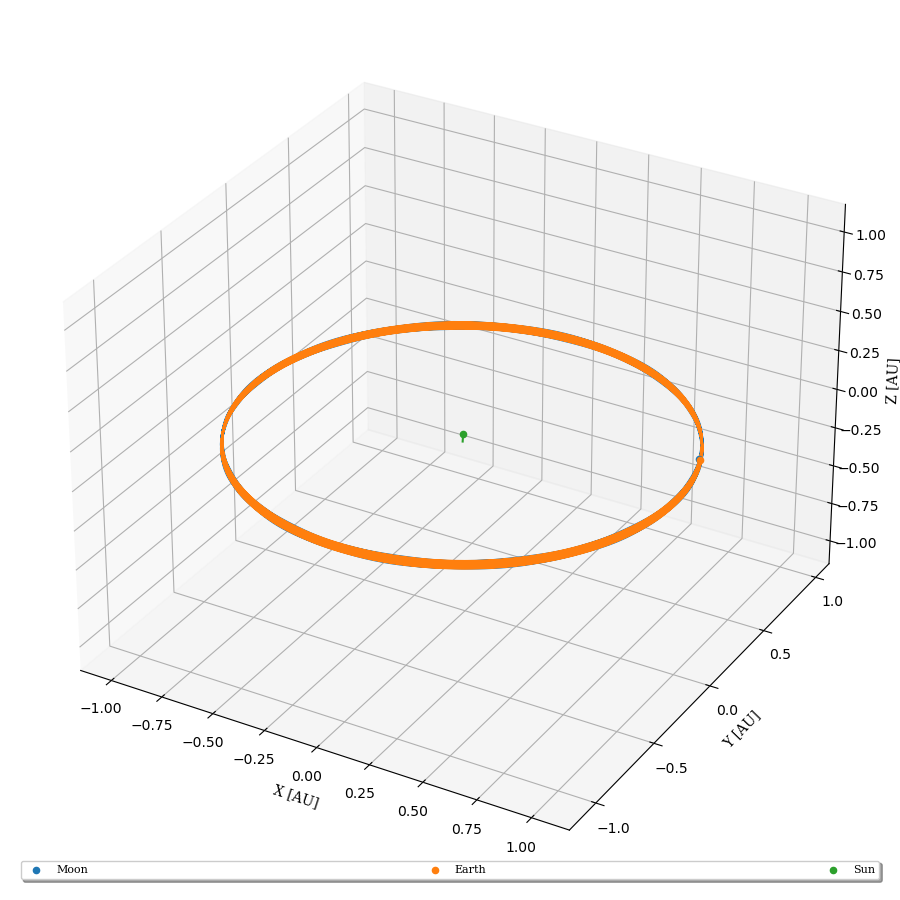

In [8]:
plot_n_body_sol(sol=sol_MES[0], labels=list(data.index.values))

# How to know if there is an eclipse?

Here we are going to use a geometric argument to establish wheter we have an eclipse or not. From the vector of possition of the Earth and the Sun we can write the symetric equations of the line between them, we will have an eclipse if the possition of the Moon fullfills those equations.

Lets say the Earth has a position vector given by $R_{E}=(x_E, y_E, z_E)$ and for the Sun we have $R_{S}=(x_S, y_S, z_S)$, so, the vectorial equation of the straight line between them is given by:

\begin{equation}
    (x, y, z) = R_E + \alpha(R_E-R_S)
\end{equation}

which give us the symetric equations:
\begin{equation}
    \alpha = \frac{x-x_E}{x_E-x_S}\\
    \alpha = \frac{y-y_E}{y_E-y_S}\\
    \alpha = \frac{z-z_E}{z_E-z_S}
\end{equation}

We will have an eclipse if the possition of the Moon fullfills these equations, that is, if we obtain the same $\alpha$ parammeter from all the three equations. This situation is almost imposible, but we can ask to have three $\alpha$'s such their differences is as small as a given tolerance $tol$ parammeter. The possition vector of the Moon is given by $R_{M}=(x_M, y_M, z_M)$ so, from the symetric equations:

\begin{equation}
    \alpha_x = \frac{x_M-x_E}{x_E-x_S}\\
    \alpha_y = \frac{y_M-y_E}{y_E-y_S}\\
    \alpha_z = \frac{z_M-z_E}{z_E-z_S}
\end{equation}

we will say that we have an eclipse if the following conditions are fullfilled:

\begin{equation}
    |\alpha_x-\alpha_y|\leq \text{tol}\\
    |\alpha_y-\alpha_z|\leq \text{tol}
\end{equation}

those conditions implie that $\alpha_x \approx\alpha_y\approx\alpha_z$. As the Moon, the Earth and the Sun are moving, their possitios are a finction of the time, so the equations must be computed for each of those times.

In [10]:
# Possition vector for each, Moon, Earth and Sun
rs_Moon  = sol_MES[0][:,0:3]
rs_Earth = sol_MES[0][:,6:9]
rs_Sun   = sol_MES[0][:,12:15]

# alphas
alpha_x = (rs_Moon[:,0] - rs_Earth[:,0]) / (rs_Earth[:,0] - rs_Sun[:,0])
alpha_y = (rs_Moon[:,1] - rs_Earth[:,1]) / (rs_Earth[:,1] - rs_Sun[:,1])
alpha_z = (rs_Moon[:,2] - rs_Earth[:,2]) / (rs_Earth[:,2] - rs_Sun[:,2])

# testing tolerance
tol = 1.13e-2
id_ts_MES        = np.linspace(0, len(ts_MES)-1, len(ts_MES), dtype=int)
id_eclipse_times = id_ts_MES[(abs(alpha_x-alpha_y) < tol) & (abs(alpha_y-alpha_z) < tol)]

# The amount of eclipses
print(f"{len(eclipse_times)}")

84


In [11]:
id_eclipse_times

array([  830,  2585,  3178,  3959,  6506,  6697,  7874,  8265,  8655,
        9642, 10615, 11005, 12387, 13175, 14346, 15916, 17670, 19044,
       20219, 21588, 21782, 22174, 22769, 25120, 26478, 27657, 29039,
       29429, 29821, 31963, 32170, 35303, 37456, 38042, 39808, 39998,
       40203, 40597, 42346, 42553, 43520, 45297, 46261, 48038, 49209,
       50385, 51358, 54102, 54294, 55861, 58210, 58599, 61160, 62124,
       63509, 64288, 64474, 68592, 69178, 69765, 71328, 71719, 74066,
       75245, 77408, 80148, 81900, 82102, 83082, 83472, 84251, 84448,
       86794, 87390, 87579, 87970, 88360, 89739, 92482, 93448, 95222,
       96394, 97568, 97960])